In [1]:
import torch
from torchvision.transforms import functional as F
import torch.nn.functional as tnf
from torchvision import transforms
from PIL import Image
import math
import matplotlib.pyplot as plt

## Recadrage des images

Taille attendue : 200x200.

In [2]:
def preprocess_image(image, target_size=(200, 200), crop="lower", left_offset=0, top_offset=0):
    """
    Prétraite une image en la convertissant en nuances de gris, puis en la redimensionnant et la recadrant selon les paramètres donnés.
    :param image: Image à traiter
    :param target_size: Taille cible de l'image
    :param crop: Position du crop (lower ou center)
    :param left_offset: Décalage à appliquer à gauche
    :param top_offset: Décalage à appliquer en haut
    """

    # Convertir en nuances de gris
    image_gray = F.to_grayscale(image, num_output_channels=1)

    # Caclul des différences de taille entre l'image et la taille cible
    width, height = image_gray.size
    width_delta = (width - target_size[0])
    height_delta = (height - target_size[1])

    # L'image est centrée dans sa longueur, on calcule le crop à appliquer (floor et ceil pour corriger les erreurs d'arrondi)
    left = math.floor(width_delta / 2)
    right = math.ceil(width - width_delta / 2)

    # L'image peut être centrée ou plaquée sur le bas (afin de garder au maximum la ligne blanche)
    if crop == "lower":
        top = height_delta
        bottom = height
    else:
        top = math.floor(height_delta / 2)
        bottom = math.ceil(height - height_delta / 2)

    # Calcul du crop final et applique l'offset si besoin
    crop = (left + left_offset, top + top_offset, right + left_offset, bottom + top_offset)
    return image_gray.crop(crop)

In [3]:
raw_image = Image.open('scotch/img1.png')
processed_image = preprocess_image(raw_image)

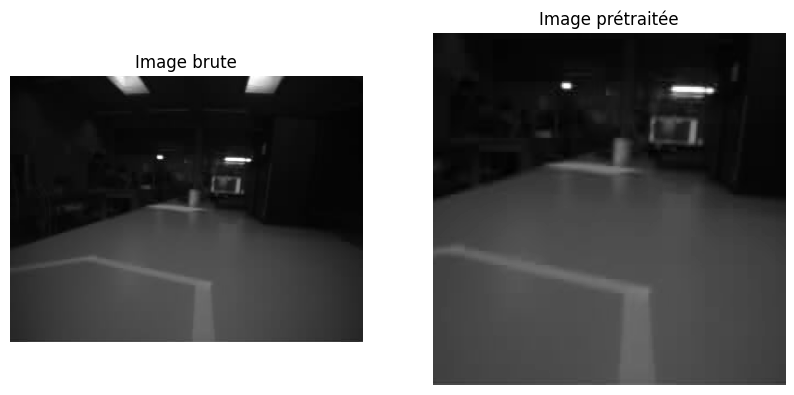

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(raw_image)
plt.title('Image brute')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(processed_image, cmap='gray')
plt.title('Image prétraitée')
plt.axis('off')
plt.show()

## Filtre de Sobel

In [11]:
# Définir les noyaux Sobel pour les dérivées horizontales et verticales
vert_values = [3., 6.]
sobel_kernel_x = torch.tensor([[-vert_values[0], 0., vert_values[0]],
                               [-vert_values[1], 0., vert_values[1]],
                               [-vert_values[0], 0., vert_values[0]]])

horz_values = [1., 2.]
sobel_kernel_y = torch.tensor([[-horz_values[0], -horz_values[1], -horz_values[0]],
                               [0., 0., 0.],
                               [horz_values[0], horz_values[1], horz_values[0]]])

# Ces noyaux doivent être étendus pour s'adapter aux dimensions de l'image [batch_size, channels, height, width]
# [out_channels, in_channels, height, width]
sobel_kernel_x = sobel_kernel_x.view((1, 1, 3, 3))
sobel_kernel_y = sobel_kernel_y.view((1, 1, 3, 3))

# Vérifiez si CUDA est disponible et définissez le périphérique en conséquence
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Convertir les noyaux en types de données adaptés pour les calculs de convolution
sobel_kernel_x = sobel_kernel_x.to(device, dtype=torch.float32)
sobel_kernel_y = sobel_kernel_y.to(device, dtype=torch.float32)

# Fonction pour appliquer le filtre Sobel à une image
def sobel_filter(preprocessed_image, threshold=0.5):
    # Convertir l'image en tenseur PyTorch
    transform = transforms.ToTensor()
    image_tensor = transform(preprocessed_image).to(device)
    
    # Ajouter des dimensions de batch et de canal pour correspondre à la forme [B, C, H, W]
    image_tensor = image_tensor.unsqueeze(0)

    # Appliquer le filtre de Sobel sur l'image tensorielle
    Gx = tnf.conv2d(image_tensor, sobel_kernel_x, padding=1)
    Gy = tnf.conv2d(image_tensor, sobel_kernel_y, padding=1)

    # Calculer la magnitude du gradient
    sobel_magnitude = torch.sqrt(Gx**2 + Gy**2)

    # Appliquer un seuillage pour binariser l'image
    sobel_binary = torch.where(sobel_magnitude > threshold, torch.tensor(1.0), torch.tensor(0.0))
    
    # Convertir le gradient en image PIL pour l'affichage
    sobel_magnitude_image = transforms.ToPILImage()(sobel_binary.squeeze(0))
    
    return sobel_magnitude_image

def plot_image(sobel_image, i):
    plt.imshow(sobel_image, cmap='gray')
    plt.title("Sobel Filter on img " + i)
    plt.axis('off')
    plt.show()

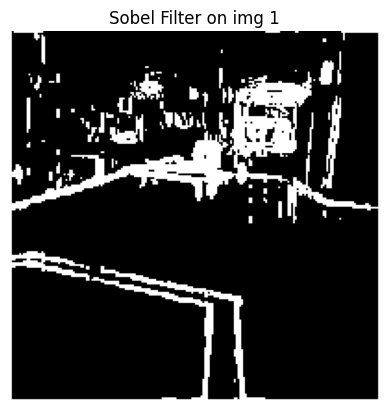

In [18]:
sobel_image = sobel_filter(processed_image, 0.4)

plot_image(sobel_filter(processed_image, 0.2), '1')

## Test complet

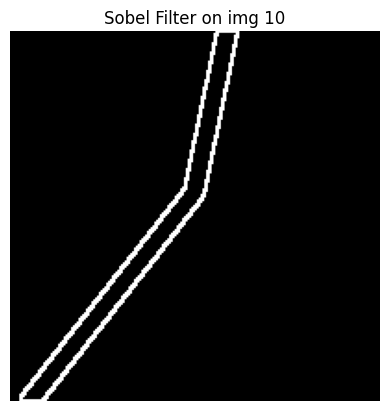

In [22]:
test_image_path = '../scripts/test_img/0__10_0.png'

raw_test_image = Image.open(test_image_path)
processed_test_image = preprocess_image(raw_test_image)

sobel_test_image = sobel_filter(processed_test_image, 0.2)

plot_image(sobel_test_image, '10')

# Export the Sobel filtered image
sobel_test_image.save('sobel_test_image.png')